In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import analyze # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm


%matplotlib inline

In [31]:
ACTUALLY_OFF = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 
                130, 134, 135, 139, 148, 150, 152, 162, 178, 183,
                190, 198, 206, 213, 214, 234, 239, 244]

In [37]:
def data_exists(run_number):
    return os.path.exists('./data/run_%05d.h5' % run_number)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

runlists = [f for f in os.listdir('./runlists')]

bottom_runs = []
accs = []
errors = []

missing_runs = []

for f in tqdm(sorted(runlists)):
    runlist = file_to_list(f)
    if not all_data_exists(runlist):
        #print('data missing for %s' % f)
        for r in runlist:
            if not data_exists(r):
                missing_runs.append(r)
        continue
    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]
    
    thresholds = analyze.get_thresholds(analyze.find_regular_run(bottom_run))
    
    acc, acc_errs = analyze.acceptance_3runs(bottom_run, topbulk_run, topring_run, thresholds)
    occ, occ_errs = analyze.occupancy_3runs(bottom_run, topbulk_run, topring_run)
    
    on_channels = np.where(occ > 0.05)[0]
    
    if len(on_channels) < 200:
        print('LED likely OFF for %s' % f)
        continue
    
    acc = acc[on_channels]
    acc_errs = acc_errs[on_channels]
    
    accs.append(np.median(acc))
    errors.append(np.sqrt((acc_errs**2).sum()) / len(on_channels))
    bottom_runs.append(bottom_run)
    

 18%|█▊        | 18/99 [00:35<02:55,  2.17s/it]/home/ershockley/analysis/SPE/analyze.py:63: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/home/ershockley/analysis/SPE/analyze.py:63: RuntimeWarning: invalid value encountered in true_divide
  return 1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
 29%|██▉       | 29/99 [01:02<02:50,  2.44s/it]

LED likely not on for runlist_13433_13434_13435.txt


 32%|███▏      | 32/99 [01:09<02:36,  2.34s/it]

LED likely not on for runlist_14088_14089_14090.txt


100%|██████████| 99/99 [03:01<00:00,  2.45s/it]


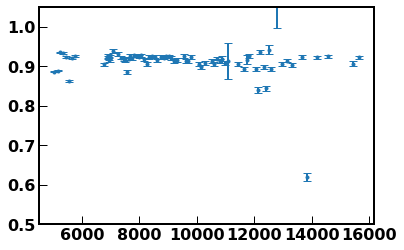

In [38]:
plt.errorbar(bottom_runs, accs, yerr=errors, linestyle='None', marker='.')
plt.ylim(0.5, 1.05)
plt.show()

In [50]:
data_dir_base = './data'
def acceptance_curve_3runs(bottom_run, topbulk_run, topring_run):
    ret_acc, ret_errs = np.ones((248, 1099)), np.ones((248, 1099))
    run_list = [bottom_run, topbulk_run, topring_run]
    channel_lists = [channel_dict['bottom_channels'],
                     channel_dict['top_bulk'],
                     channel_dict['top_outer_ring']]
    for run, ch_list in zip(run_list, channel_lists):
        path = os.path.join(data_dir_base, 'run_%05d.h5' % run)
        if not os.path.exists(path):
            print("Acceptance data does not exist for run %d" % run)
        s = analyze.SPE(path)
        frac, errs = s.acceptance_by_channel
        ret_acc[ch_list,:] = frac[ch_list,:]
        ret_errs[ch_list,:] = errs[ch_list,:]
        x = s.data['bin_centers']
    return x, ret_acc, ret_errs

In [51]:
bottom_runs = np.array(bottom_runs)
accs = np.array(accs)

print(bottom_runs[np.where(accs < 0.7)])

[13837]


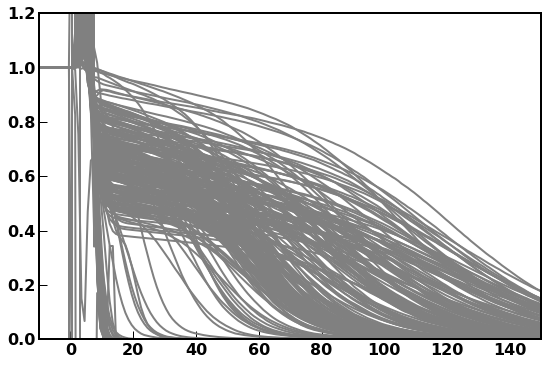

In [57]:
runlist = tuple(file_to_list('runlist_13837_13838_13839.txt'))

x, acc, errs = acceptance_curve_3runs(*runlist)


plt.figure(figsize = (9,6))
for curve, err in zip(acc, errs):
    plt.plot(x, curve, color='grey')
plt.xlim(-10,150)
plt.ylim(0, 1.2)
plt.show()


In [ ]:
runlist='runlist_14192_14193_14195.txt'
runs = runlist.split('_')[1:4]
bot_run = int(runs[0])
tb_run = int(runs[1])
tr_run = int(runs[2][:-4])

thresholds = get_thresholds(find_regular_run(bot_run))

acc, err = acceptance_3runs(bot_run, tb_run, tr_run, thresholds)
occ, occ_err = occupancy_3runs(bot_run, tb_run, tr_run)

In [ ]:
plt.hist(occ, bins=50, range=(0,1.1))
plt.xlim(0,0.2)
plt.show()

In [ ]:
myoff = np.where(occ < 0.07)[0]
print('in mine but not acutally:', [ch for ch in myoff if ch not in actually_off])
print('opposite: ', [ch for ch in actually_off if ch not in myoff])

In [ ]:
path = './data/run_%05d.h5' % tr_run
s = SPE(path)
vals_to_check = [3,4,5,6,7,8,9]
occ_array = np.ones((248, len(vals_to_check)))
for i, val in enumerate(vals_to_check):
    occ_array[:,i] = -1*np.log(s.make_correction(val, 'amplitude'))
occ = np.mean(occ_array, axis=1)
myoff = np.where(occ < 0.1)[0]

In [ ]:
plt.plot(s.data['bin_centers'], s.data['LED_amplitude'][:,0], color='black')
plt.plot(s.data['bin_centers'], s.data['noise_amplitude'][:,0], color='red')
plt.yscale('log')
plt.xlim(-50, 250)
plt.show()

In [ ]:
occ

In [ ]:
data_dir_base = "./data"

run_number = 15628
path = os.path.join(data_dir_base, 'run_%05d.h5' % run_number)
if not os.path.exists(path):
    print("Acceptance data does not exist for run %d" % run_number)
s = SPE(path)
acc_fracs = []

        

In [ ]:
ch = 0

acc = s.acceptance(6, 'amplitude')
acc2 = s.acceptance_curves[ch]
acc2_errs = s.acceptance_errors[ch]
plt.plot(s.data['bin_centers'], acc[ch])
plt.errorbar(s.data['bin_centers'], acc2, yerr=acc2_errs)
plt.xlim(-10, 150)
plt.show()

In [ ]:
def acceptance_fraction(run_number, thresholds):
    path = os.path.join(data_dir_base, 'run_%05d.h5' % run_number)
    if not os.path.exists(path):
        print("Acceptance data does not exist for run %d" % run_number)
    s = SPE(path)
    frac_array = np.ones((248, s.big_array.shape[-1]))
    ch_index = np.arange(248)
    thresholds = np.array(thresholds)
    bin0 = np.where(s.data['bin_centers'] == 0.5)[0][0]
    for i in range(s.big_array.shape[-1]):
        frac_array[:,i] = s.big_array[...,i][ch_index, thresholds[:248] + bin0]
    acc_frac = np.mean(frac_array, axis=1)
    acc_errs = np.std(frac_array, axis=1)
    return acc_frac, acc_errs

In [ ]:
run_number = 15628
s = SPE('data/run_%05d.h5' % run_number)
thresh = get_thresholds(find_regular_run(run_number))
frac, errs = acceptance_fraction(run_number, thresh)

In [ ]:
arr = np.ones(5)
arr[[2,4]] = [2,2]
arr

In [ ]:
from channel_dict import channel_dict

bot_run = 15625
tb_run = 15627
tr_run = 15628

bottom = channel_dict['bottom_channels']
topbulk = channel_dict['top_bulk']
topring = channel_dict['top_outer_ring']

real_acc, real_errs = np.ones(248), np.ones(248)

for run, channels in zip([bot_run, tb_run, tr_run], [bottom, topbulk, topring]):
    frac, errs = acceptance_fraction(run_number, thresh)
    real_acc[channels] = frac[channels]
    real_errs[channels] = errs[channels]

In [ ]:
arr  = s.big_array

In [ ]:
corrections = s.make_correction(6, 'amplitude')
corrections

In [ ]:
chs = np.arange(248)
thresh = np.array(thresh[:248])
ch = 139

frac_array = np.ones((248, arr.shape[-1]))
plt.figure(figsize=(9,6))
for i in range(s.big_array.shape[-1]):
    tmp = arr[...,i]
    frac_array[:,i] = tmp[chs, 100+thresh]
    plt.plot(s.data['bin_centers'], s.big_array[ch,:,i])
    #frac_array[:,i] = arr[...,i][list(np.arange(248)), thresh]


plt.errorbar([thresh[ch]], np.mean(frac_array[ch]), yerr=np.std(frac_array[ch]))
plt.xlim(0,150)
frac_array[ch]

In [ ]:
thresh = np.array(thresh)
len(thresh)

In [ ]:
plt.plot(s.data['bin_centers'], s.data['LED_amplitude'][:,ch])
plt.plot(s.data['bin_centers'], s.data['noise_amplitude'][:,ch])
plt.yscale('log')
plt.xlim(-20,20)